In [1]:
import os
import json
import torch
import random

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from pytoda.proteins.processing import IUPAC_VOCAB
from paccmann_predictor.utils.utils import get_device

print(torch.cuda.is_available())

seed_number = 10000

torch.manual_seed(seed_number)
random.seed(seed_number)
np.random.seed(seed_number)
torch.cuda.manual_seed(seed_number)

True


In [2]:
from TCRcrossreactivity.models import MODEL_FACTORY
from TCRcrossreactivity.utils.utils import tokenize_sequence, Dataset, GELU, MySampler, \
        create_df_train_test, avg_perplexity, mean_seq_accuracy, multi_label_accuracy

# Prepare data and model

In [3]:
# Hyper length
max_length_tcr = 127
max_length_epitope = 20

device = get_device()

data_root_dir = "/dccstor/tcr_data/cvae_data_copy"
print(os.listdir(data_root_dir))
# model_dir = "/dccstor/tcr_data/cvae_models/fold0/"
model_dir = "/dccstor/tcr_data/cvae_models/fold0/run_cvae_covid_tcr_split_fold0_tcr_full_TAPE_output + bio_05162022_0745/checkpoints"
print(os.listdir(model_dir))
model_params_dir = "/dccstor/tcr_data/cvae_models/fold0/run_cvae_covid_tcr_split_fold0_tcr_full_TAPE_output + bio_05162022_0745/model_params.json"

['tcr.csv', 'epitopes.smi', 'tcr_full.csv', 'epitopes.csv', 'tcr_split', 'bert_amino_embeddings.npy']
['epoch_9.pth', 'epoch_7.pth', 'epoch_13.pth', 'epoch_2.pth', 'epoch_15.pth', 'epoch_6.pth', 'epoch_20.pth', 'epoch_21.pth', 'epoch_22.pth', 'epoch_12.pth', 'epoch_19.pth', 'epoch_5.pth', 'epoch_8.pth', 'epoch_4.pth', 'epoch_16.pth', 'epoch_10.pth', 'epoch_18.pth', 'epoch_17.pth', 'epoch_14.pth', 'epoch_11.pth', 'epoch_3.pth', 'epoch_1.pth']


In [4]:
def load_params():
    params_filepath=model_params_dir
    params = {}
    with open(params_filepath) as fp:
        params.update(json.load(fp))
    return params

params = load_params()

In [5]:
def prepare_data(params):
    tcr_filepath = os.path.join(data_root_dir, "tcr_full.csv")
    epitope_filepath = os.path.join(data_root_dir, "epitopes.csv")
    data_binding_ids_filepath_train = os.path.join(data_root_dir, "tcr_split/fold0/train+covid.csv")
    data_binding_ids_filepath_test = os.path.join(data_root_dir, "tcr_split/fold0/test+covid.csv")
    
    df_train, df_test = create_df_train_test(tcr_filepath,
                                             epitope_filepath,
                                             data_binding_ids_filepath_train,
                                             data_binding_ids_filepath_test)
    
    # extract seq id, tcr starts from 2, epitope from 3
    tcr_id_train, ep_id_train = df_train.tcr_id.values - 2, df_train.ep_id.values - 3
    tcr_id_test, ep_id_test = df_test.tcr_id.values - 2, df_test.ep_id.values - 3

    # extract labels
    label_train, label_test = df_train.label.values, df_test.label.values

    # extract sequences
    tcr_seq_train = df_train.tcr.values
    epitope_seq_train = df_train.epitope.values

    tcr_seq_test = df_test.tcr.values
    epitope_seq_test = df_test.epitope.values

    # tokenize sequences
    train_tcr, train_ep, train_tcr_target, train_ep_target = \
        tokenize_sequence(tcr_seq_train, epitope_seq_train, max_length_tcr, max_length_epitope)
    test_tcr, test_ep, test_tcr_target, test_ep_target = \
        tokenize_sequence(tcr_seq_test, epitope_seq_test, max_length_tcr, max_length_epitope)
    
    # extract train and test data
    train_dataset = Dataset(train_tcr, train_ep, train_tcr_target, train_ep_target, tcr_id_train, ep_id_train,
                            label_train)
    test_dataset = Dataset(test_tcr, test_ep, test_tcr_target, test_ep_target, tcr_id_test, ep_id_test, label_test)
    
    batch_size_train = params['batch_size']
    batch_size_test = len(test_dataset)
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train,
                              sampler=MySampler(train_dataset, batch_size=batch_size_train,
                                                proportion_of_labeled_data_per_batch=params[
                                                     'proportion_of_labeled_data_per_batch']),
                              num_workers=params['num_workers'], pin_memory=True, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
    return train_loader, test_loader

In [6]:
train_loader, test_loader = prepare_data(params)

/u/shuaijun/TCR_crossreactivity/TCRcrossreactivity/utils/utils.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_train_ids_df_labeled.label[np.isnan(pairs_train_ids_df_labeled.label.values)] = 2


In [7]:
def prepare_model(model_dir, epoch_num):
    
    AA_to_token_VOCAB = IUPAC_VOCAB
    
    # Activation function ffnn - encoder
    act_fn_enc = GELU() if params['encoder']['activation'] == 'gelu' else nn.ReLU()
    
    params_encoder = params['encoder']
    params_encoder['activation'] = act_fn_enc
    params_decoder = params['decoder']
    params_classifier = params['classifier']

    # define encoder
    encoder = MODEL_FACTORY['encoder'](
        tcr_vocabulary_size=len(AA_to_token_VOCAB), epitope_vocabulary_size=len(AA_to_token_VOCAB),
        tcr_seq_length=max_length_tcr, epitope_seq_length=max_length_epitope,
        **params_encoder).to(device)
    
    # define decoder
    decoder = MODEL_FACTORY['decoder'](
        hidden_size_tcr=params['encoder']['latent_dim'], hidden_size_ep=params['encoder']['latent_dim'],
        vocab_size_tcr=len(AA_to_token_VOCAB), vocab_size_ep=len(AA_to_token_VOCAB),
        tcr_embedding_size=encoder.get_input_size_tcr, ep_embedding_size=encoder.get_input_size_ep,
        **params_decoder).to(device)

    # define classifier
    classifier = MODEL_FACTORY['classifier'](input_dim=params['encoder']['latent_dim'], **params_classifier).to(device)
    
    model = MODEL_FACTORY['classifier_vae'](encoder, decoder, classifier).to(device)
    
    model_path = os.path.join(model_dir, epoch_num)
    if os.path.isfile(model_path):
        model.load(model_path, map_location=device)

    return model

In [8]:
model = prepare_model(model_dir, 'epoch_21.pth')

/u/shuaijun/.conda/envs/tcr/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [9]:
submodules_list = ['classifier', 'dense_layers', 'dense_0']
model.cuda()

VaeClassifier(
  (encoder): MultiHeadAttentionEncoder(
    (act_fn): GELU()
    (tcr_tape): FeatureLookUp(
      (embedding_bio): Embedding(32, 14, padding_idx=0)
    )
    (ep_tape): FeatureLookUp(
      (embedding_bio): Embedding(32, 14, padding_idx=0)
    )
    (tcr_emb_decode): FeatureLookUp(
      (learned_embeddings): Embedding(32, 768, padding_idx=0)
      (embedding_bio): Embedding(32, 14, padding_idx=0)
    )
    (ep_emb_decode): FeatureLookUp(
      (learned_embeddings): Embedding(32, 768, padding_idx=0)
      (embedding_bio): Embedding(32, 14, padding_idx=0)
    )
    (tcr_emb_proj): Linear(in_features=782, out_features=120, bias=True)
    (ep_emb_proj): Linear(in_features=782, out_features=120, bias=True)
    (tcr_self_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=120, bias=True)
    )
    (ep_self_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=120, out_features=

In [10]:
from dante.latent_features.extractor import ModelFeatureExtractor

class CvaeExtractor(ModelFeatureExtractor):
    
    def batch_to_input(self, batch):
        
        tcr_input, ep_input, tcr_target, ep_target, y_tcr, y_epitope, tcr_id, ep_id, labels = batch
        
        tcr_mask = (tcr_input == 0).to(device)
        ep_mask = (ep_input == 0).to(device)
        ep_input = ep_input.to(device)
        tcr_input = tcr_input.to(device)
        ep_target = ep_target.to(device)
        tcr_target = tcr_target.to(device)
        labels = labels.to(device)
        tcr_id = tcr_id.to(device)
        ep_id = ep_id.to(device)
        
        return ep_input, tcr_input, ep_target, tcr_target, labels, tcr_mask, ep_mask, tcr_id, ep_id

In [ ]:
exp_name = 'cvae2'

In [ ]:
train_latent_features = CvaeExtractor(
    model = model, 
    dataloader = (train_loader, 'train'), 
    submodules_list = submodules_list,
    model_name = exp_name,
    out_dir = './output'
).run()

In [ ]:
torch.save(train_latent_features, 'output/train_latent_f_c_d0.pt')

In [ ]:
test_latent_features = CvaeExtractor(
    model = model, 
    dataloader = (test_loader, 'test'), 
    submodules_list = submodules_list,
    model_name = exp_name,
    out_dir = './output'
).run()

In [ ]:
torch.save(test_latent_features, 'output/test_latent_f_c_d0.pt')

In [11]:
def extract_y_hat_true(model, data_loader):
    
    y_true = []
    y_hat = []
    
    model.eval()
    for tcr_input, ep_input, tcr_target, ep_target, y_tcr, y_epitope, tcr_id, ep_id, labels in tqdm(data_loader):
        
        tcr_mask = (tcr_input == 0).to(device)
        ep_mask = (ep_input == 0).to(device)
        ep_input = ep_input.to(device)
        tcr_input = tcr_input.to(device)
        ep_target = ep_target.to(device)
        tcr_target = tcr_target.to(device)
        labels = labels.to(device)
        tcr_id = tcr_id.to(device)
        ep_id = ep_id.to(device)
        
        labels = labels.cpu()
        y_true.append(labels)
        
        with torch.no_grad():
            out_tcr, out_ep, mu, logvar, batch_y_hat = \
                model(ep_input, tcr_input, ep_target, tcr_target, labels, tcr_mask, ep_mask, tcr_id, ep_id)
        
        batch_y_hat = batch_y_hat.cpu()
        y_hat.append(batch_y_hat)

    y_hat = torch.cat(y_hat)
    y_true = torch.cat(y_true)
    
    return y_hat, y_true

In [12]:
y_train_hat, y_train_true = extract_y_hat_true(model, train_loader)
y_test_hat, y_test_true = extract_y_hat_true(model, test_loader)

  0%|          | 0/7810 [00:01<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
torch.save(y_train_hat, 'output/y_train_hat.pt')
torch.save(y_train_true, 'output/y_train_true.pt')
torch.save(y_test_hat, 'output/y_test_hat.pt')
torch.save(y_test_true, 'output/y_test_true.pt')

In [13]:
model_dirs = ['run_cvae_covid_tcr_split_fold0_tcr_full_TAPE_output + bio_05162022_1407',
              'run_cvae_covid_tcr_split_fold0_tcr_full_TAPE_output + bio_05162022_1411',
              'run_cvae_covid_tcr_split_fold0_tcr_full_TAPE_output + bio_05162022_1413',
              'run_cvae_covid_tcr_split_fold0_tcr_full_TAPE_output + bio_05162022_1415',
              'run_cvae_covid_tcr_split_fold0_tcr_full_TAPE_output + bio_05162022_1420']

y_hat_ensemble = []
for i in model_dirs:
    model_dir = os.path.join("/dccstor/tcr_data/cvae_models/fold0", i, 'checkpoints')
    epoch_num = 'epoch_13.pth'
    model_temp = prepare_model(model_dir, epoch_num)
    model_temp = model_temp.cuda()
    y_test_hat_temp, y_test_true_temp = extract_y_hat_true(model_temp, test_loader)
    y_test_hat_temp = nn.functional.softmax(y_test_hat_temp[:, :-1], dim=1)[:, 0]
    y_hat_ensemble.append(y_test_hat_temp)

/u/shuaijun/.conda/envs/tcr/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/1 [00:00<?, ?it/s]

/u/shuaijun/.conda/envs/tcr/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/1 [00:00<?, ?it/s]

/u/shuaijun/.conda/envs/tcr/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/1 [00:00<?, ?it/s]

/u/shuaijun/.conda/envs/tcr/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/1 [00:00<?, ?it/s]

/u/shuaijun/.conda/envs/tcr/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
y_hat_ensemble = torch.stack(y_hat_ensemble).mean(0)

In [15]:
def aleatoric_uncertainty(prediction_proba):
    return -(np.log2(prediction_proba) * prediction_proba + np.log2(1-prediction_proba) * (1-prediction_proba))

In [16]:
entropy_test = aleatoric_uncertainty(y_hat_ensemble)

In [17]:
entropy_test

tensor([0.8433, 0.9706, 0.9808,  ..., 0.2980, 0.9136, 0.9340])

<AxesSubplot:ylabel='Count'>

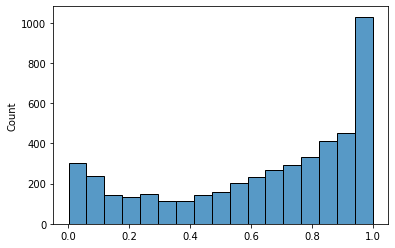

In [18]:
sns.histplot(entropy_test)

In [94]:
train_latent_features = torch.load('output/train_latent_f_c_d1.pt')
test_latent_features = torch.load('output/test_latent_f_c_d1.pt')

In [18]:
from leven import levenshtein 
import editdistance
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import fastcluster as fc

In [97]:
z = fc.linkage(test_latent_features, 'average')

In [ ]:
dn = dendrogram(z)

In [43]:
clusters = cut_tree(z, height=15).astype(int)

4718

In [57]:
y_train_label = (y_train_true != 2).nonzero()

In [58]:
train_latent_features = train_latent_features[y_train_label]

In [59]:
train_latent_features = train_latent_features.squeeze()

In [85]:
from dante.layer_scoring.aklpe import Aklpe
from dante.nearest_neighbors.pynndescent import NearestNeighbors

nns = NearestNeighbors

aklpe = Aklpe(
    nearest_neighbors = nns,
    n_neighbors=50, 
    n_bootstraps=1)

aklpe.fit(train_latent_features.numpy())

aklpe_scores, aklpe_pvals = aklpe.score(test_latent_features.numpy())

Fit_nn: 0it [00:00, ?it/s]

g_stat:   0%|          | 0/21227 [00:00<?, ?it/s]

g_stat:   0%|          | 0/21227 [00:00<?, ?it/s]

g_stat:   0%|          | 0/2359 [00:00<?, ?it/s]

g_stat:   0%|          | 0/2359 [00:00<?, ?it/s]

In [86]:
X_embedded = TSNE(n_components=2).fit_transform(test_latent_features.numpy())

/u/shuaijun/.conda/envs/tcr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/u/shuaijun/.conda/envs/tcr/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [87]:
X_embedded

array([[ -3.916531 ,  30.791843 ],
       [-10.682735 ,  16.283554 ],
       [ -3.9959188,  12.1719885],
       ...,
       [ 12.326643 ,  38.086887 ],
       [-21.20643  ,  14.4955635],
       [ -5.2454443,  16.952036 ]], dtype=float32)

In [51]:
X_pd = pd.read_csv('test_latent_features_c_d1_3d_tsne.csv', index_col=0)

In [52]:
X_pd['label'] = clusters

In [53]:
fig = px.scatter_3d(X_pd, x='x', y='y', z='z', color='label')

In [54]:
X_pd.to_csv("test_latent_features_c_d1_3d_tsne_hc.csv")

<AxesSubplot:>

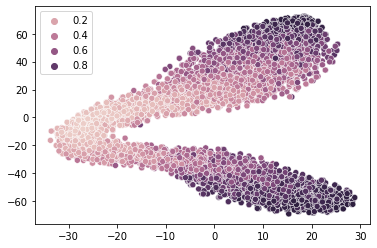

In [88]:
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=1-aklpe_pvals)

<AxesSubplot:ylabel='Count'>

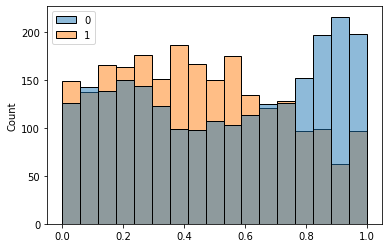

In [89]:
sns.histplot(x=1-aklpe_pvals, hue=y_test_true)

<AxesSubplot:ylabel='Count'>

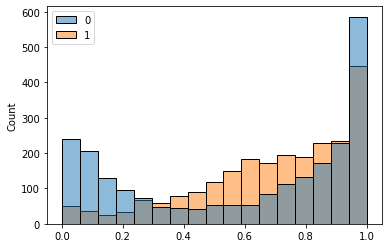

In [90]:
sns.histplot(x=entropy_test, hue=y_test_true)

<AxesSubplot:>

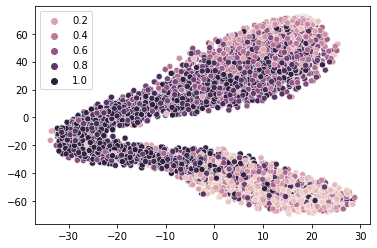

In [91]:
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=entropy_test)

<AxesSubplot:>

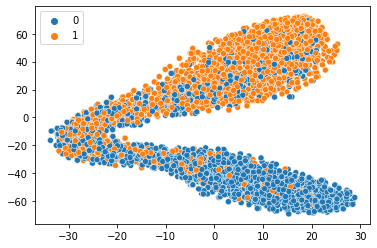

In [92]:
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y_test_true)

Text(336.9714285714286, 0.5, 'Aleatoric u')

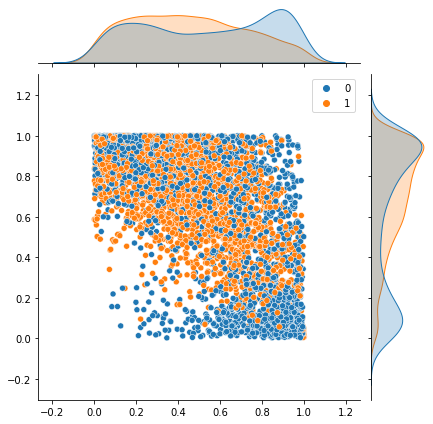

In [93]:
sns.jointplot(y=entropy_test, x=1-aklpe_pvals, hue=y_test_true)
plt.xlabel('Epistemic u')
plt.ylabel('Aleatoric u')

In [ ]:
# Findings:
# 1. For the right bottom corner, the model is pretty sure about out-of-distribution non-binding points
# 2. For the left up corner, the binding points and non-binding points have mixed together, and the model are not certain about the predictions
# 3. For the left bottom corner, we dont have many in-distribution and confident predictions.
# 4. For the right up corner, not many binding points are out-of-distribution, but a lot non-binding points are. And the model is not certain.
